In [217]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sympy as sp

from astropy import units as u
from astropy import constants as const
from matplotlib import pyplot as plt
from scipy.integrate import quad
from scipy.optimize import approx_fprime

from astropy.cosmology import FlatLambdaCDM
cosmo=FlatLambdaCDM(70, 0.3)

import iqbal_agn_heating_functions as iq

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# model consts
h70=1
P0=6.85
c500=1.09
gamma=0.31
alpha=1.07
beta=5.46

gamma_b=4./3.

In [27]:
def E(z): #ratio of the Hubble constant at redshift z to its present value
    return cosmo.H(z)/cosmo.H(0)

In [28]:
def P500(z, M500):
    M500=M500.to(u.Msun)
    return ((1.65*1e-3*E(z)**(8/3)
            *(M500/(3*1e14*h70**(-1)*u.Msun))**2/3 
            *h70**2 * u.keV * u.cm**-3)).to(u.erg/u.cm**3, equivalencies=u.mass_energy()) 

In [182]:
def Pg(x, z, M500): #x=r/r500
    #print(x)
    return (P0*P500(z, M500) #units keVcm-3
           / ((c500*x)**gamma  #unitless
              * (1+ (c500*x)**alpha)**((beta-gamma)/alpha))).to(u.erg/u.cm**3, equivalencies=u.mass_energy())

def Pg_r(r, z, M500, R500):
    return Pg(r/R500, z, M500).value

Text(0, 0.5, 'Pg (erg/cm3)')

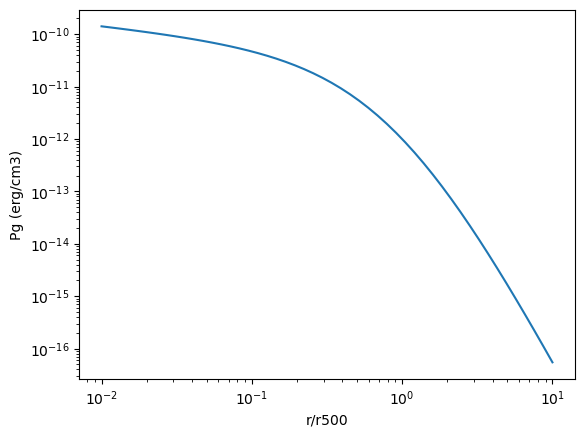

In [30]:
x=np.logspace(-2, 1)
z=3, 
M500=1e14*u.Msun
plt.loglog(x, Pg(x, z, M500).to(u.erg*u.cm**-3))
plt.xlabel('r/r500')
plt.ylabel('Pg (erg/cm3)')

[array(-4.16926492e-10),
 array(-3.50922759e-10),
 array(-2.95822756e-10),
 array(-2.49786545e-10),
 array(-2.11283834e-10),
 array(-1.79041809e-10),
 array(-1.52001813e-10),
 array(-1.29283344e-10),
 array(-1.10154191e-10),
 array(-9.40056444e-11),
 array(-8.03319605e-11),
 array(-6.87133568e-11),
 array(-5.88019453e-11),
 array(-5.0310111e-11),
 array(-4.30009061e-11),
 array(-3.66800983e-11),
 array(-3.11895547e-11),
 array(-2.64016718e-11),
 array(-2.22146051e-11),
 array(-1.85480696e-11),
 array(-1.53395232e-11),
 array(-1.25405863e-11),
 array(-1.01136177e-11),
 array(-8.02843576e-12),
 array(-6.2592626e-12),
 array(-4.78204245e-12),
 array(-3.57233002e-12),
 array(-2.60394103e-12),
 array(-1.848479e-12),
 array(-1.2757292e-12),
 array(-8.54748591e-13),
 array(-5.5535304e-13),
 array(-3.49640672e-13),
 array(-2.13223239e-13),
 array(-1.25954821e-13),
 array(-7.21002695e-14),
 array(-4.00249122e-14),
 array(-2.15706623e-14),
 array(-1.130112e-14),
 array(-5.76477985e-15),
 array(-

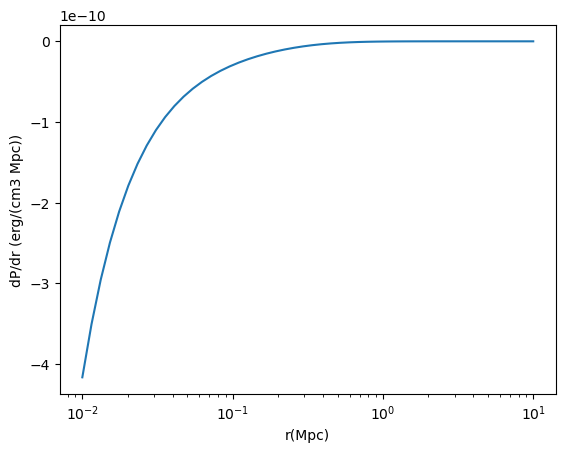

In [230]:
#r=np.logspace(-2, 1)*R500
x_vals=np.logspace(-2, 1)
rs=x_vals*R500
plt.plot(rs, [dP_dr(r, R500, M500, z) for r in rs])
plt.xlabel('r(Mpc)')
plt.ylabel('dP/dr (erg/(cm3 Mpc))')
plt.xscale('log')
#plt.yscale('symlog')
[dP_dr(r, R500, M500, z) for r in rs]


In [213]:
def dP_dr(r, R500, M500, z):
    if isinstance(R500, u.Quantity):
        R500=R500.to(u.Mpc).value
    gradients=approx_fprime(r, lambda r: Pg_r(r, z, M500, R500))[0]*u.erg/(u.cm**3 * u.Mpc)
    #print(gradients)
    return np.array(gradients)#*u.erg/(u.cm**3 * u.Mpc)
    #return gradients
    
def integrand(r, R500, M500, z, r0, rc):
    r=r*u.Mpc
    x=r/R500
    integrand=(((Pg(x, z, M500))**((gamma_b-1)/gamma_b)).to(u.erg**(1/4)*u.cm**(-3/4))
               *(1/Pg(x, z, M500)).to(u.cm**3/u.erg) 
               #*np.array([dP_dr([rad.value], R500, M500, z).to(u.erg*u.cm**(-3)*u.Mpc**(-1)) for rad in rs]) 
               *dP_dr(r.value, R500, M500, z)*(u.erg/(u.cm**3 * u.Mpc))
               *(1-np.exp(-1*r/r0)).to(1)
               *(np.exp(-1*r/rc)).to(1))
    #print(integrand)
    return integrand.to(u.erg**(1/4) * u.cm**(-3/4) *u.Mpc**(-1)).value
    
def q(R500, M500, z, r0, rc):
    rini=0.015*R500.to(u.Mpc).value
    rmax=R500.to(u.Mpc).value
    integral, _ = quad(integrand, rini, rmax, args=(R500, M500, z, r0, rc))
    return integral*(u.erg**(1/4) * u.cm**(-3/4))

In [33]:
def h(Linj, r, r0, rc, q):
    return (Linj/(4*np.pi*r**2)
            *(1-np.exp(-1*r/r0))
            *np.exp(-1*r/rc)
            *(1/q))

In [215]:
def vol_heating_rate(r, R500, M500, z, Linj, rc):
    x=r/R500
    r0=(0.015*R500).to(u.cm)
    return (h(Linj, r, r0, rc, q(R500, M500, z, r0, rc))
        *((Pg(x, z, M500))**((gamma_b-1)/gamma_b)).to(u.erg**(1/4)/u.cm**(3/4))
        *(1/r).to(1/u.Mpc)
        *(r/Pg(x, z, M500)).to(u.Mpc/(u.erg/u.cm**3))  
        *dP_dr([r.to(u.Mpc).value], R500, M500, z)).to(u.erg/(u.s*u.cm**3)) 

In [194]:
R500=1*u.Mpc
M500=2e14*u.Msun
z=0.1
rc=0.1*R500.to(u.cm)
Linj=7e44*u.erg/u.s
#rini=0.015*R500.to(u.Mpc).value
rmax=R500.to(u.Mpc).value

In [218]:
eps_01=[iq.vol_heating_rate(r, R500, M500, z, Linj, rc) for r in rs]

In [219]:
eps_03=[iq.vol_heating_rate(r, R500, M500, z, Linj, 0.3*R500) for r in rs]

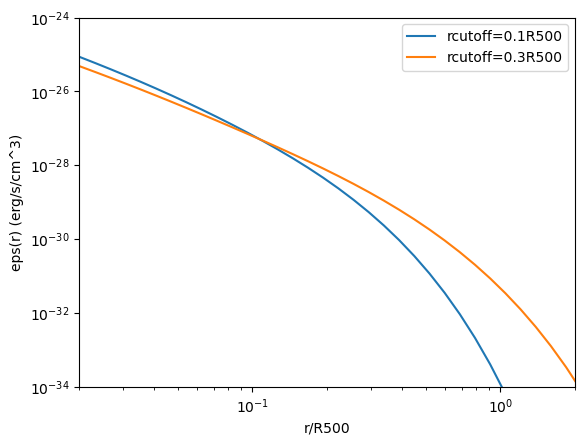

In [220]:
x_vals=np.logspace(-2, 1)
rs=x_vals*R500
plt.loglog(x_vals, eps_01, label='rcutoff=0.1R500')
plt.loglog(x_vals, eps_03, label='rcutoff=0.3R500')
plt.xlabel('r/R500')
plt.ylabel('eps(r) (erg/s/cm^3)')
plt.xlim(2*1e-2, 2*1e0)
plt.ylim(1e-34, 1e-24)
plt.legend()

In [39]:
plt.loglog(x_vals, eps_03*R500**3*4*np.pi, label='rcutoff=0.1R500')
#plt.scatter(10, 2*)

SyntaxError: invalid syntax (479398715.py, line 2)

In [ ]:
vhr=eps_03[25]
(vhr*R500**3).to(u.erg/u.s)

In [ ]:
vhr=eps_03[33]
(vhr*R500**3).to(u.erg/u.s)

In [131]:
def rho_g(r, R500, M500, z): # density profile of the baryons in the ICM
    #print([dP_dr(r0, R500, M500, z) for r0 in r])
    dPdr=[dP_dr(r0, R500, M500, z) for r0 in r]
    return (-1*(r**2/(const.G*M_enc(r, R500, M500)))*(dPdr)*const.c**2*u.erg/(u.cm**3 * u.Mpc)).to(u.Msun/u.Mpc**3, equivalencies=u.mass_energy())

In [277]:
def calculate_density_normalization(r_s, M500, R500):
    return ((M500/(4*np.pi*r_s**3))*(np.log(1+R500/r_s) - 1/(1+R500/r_s))**(-1)).to(u.Msun/u.Mpc**3)

In [285]:
def rho_nfw(r, M500, R500): # input r as scalar in Mpc
    r_s = 0.01 * u.Mpc
    rho_s = calculate_density_normalization(r_s, M500, R500)#10**18 * u.Msun/(u.Mpc)**3
    r_s = r_s.value
    y=r/r_s
    return(rho_s/(y*(1+y)**2)).to(u.Msun/u.Mpc**3)

def M_tot(rs, M500, R500):
    M = []
    for r in rs:
        r=r.value
        integrand = lambda x: 4*np.pi*x**2 * rho_nfw(x, M500, R500).value 
        M.append(quad(integrand, 0, r)[0])
    return M*u.Msun
    

In [283]:
def M_enc(r, R500, M500): #mass enclosed within radius r of an NFW profile
    # pick scale density and radius (TODO: pick these better)
    r_s = 0.01 * u.Mpc
    rho_s = calculate_density_normalization(r_s, M500, R500)#10**18 * u.Msun/(u.Mpc)**3
    #r_s = r_s.value
    
    y = r/r_s
    return ((4 * np.pi * r_s**3 * rho_s) * (np.log(1+y) - (1/(1+y)))).to(u.Msun)

In [152]:
def T_g(r, R500, M500, z):
    r=r*u.Mpc
    mu=1
    return (mu*const.m_p*Pg(r/R500, z, M500)/rho_g(r, R500, M500, z)).to(u.GeV)

In [188]:
def dT_dr(r, R500, M500, z): #BROKEN
    #R500=R500.to(u.Mpc).value
    #gradients=approx_fprime(r, lambda r: T_g(r, R500, M500,z).value)*u.GeV/(u.Mpc)
    #print(gradients)
    
    np.gradient()
    #return np.array(gradients)#*u.erg/(u.cm**3 * u.Mpc)
    #return gradients

In [104]:
# test cluster
R500=1*u.Mpc
M500=2e14*u.Msun
z=0

x_vals=np.logspace(-2, 1)
rs=x_vals*R500


In [254]:
M_tot(rs)

<Quantity [2.42715905e+08, 2.90196778e+08, 3.44320975e+08, 4.05415998e+08,
           4.73719818e+08, 5.49373400e+08, 6.32418282e+08, 7.22799102e+08,
           8.20370520e+08, 9.24907632e+08, 1.03611877e+09, 1.15365959e+09,
           1.27714734e+09, 1.40617452e+09, 1.54032129e+09, 1.67916617e+09,
           1.82229488e+09, 1.96930731e+09, 2.11982268e+09, 2.27348316e+09,
           2.42995599e+09, 2.58893460e+09, 2.75013875e+09, 2.91331400e+09,
           3.07823071e+09, 3.24468265e+09, 3.41248545e+09, 3.58147488e+09,
           3.75150519e+09, 3.92244733e+09, 4.09418740e+09, 4.26662503e+09,
           4.43967194e+09, 4.61325066e+09, 4.78729325e+09, 4.96174024e+09,
           5.13653959e+09, 5.31164585e+09, 5.48701931e+09, 5.66262534e+09,
           5.83843374e+09, 6.01441818e+09, 6.19055572e+09, 6.36682641e+09,
           6.54321284e+09, 6.71969991e+09, 6.89627444e+09, 7.07292499e+09,
           7.24964161e+09, 7.42641562e+09] solMass>

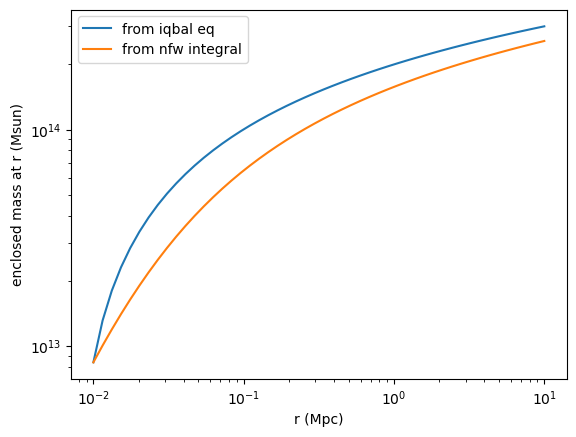

In [286]:
plt.loglog(rs, M_enc(rs, R500, M500), label='from iqbal eq')
plt.loglog(rs, M_tot(rs, M500, R500), label='from nfw integral')
plt.xlabel('r (Mpc)')
plt.ylabel('enclosed mass at r (Msun)')
plt.legend()

In [274]:
M_enc(rs, R500, M500)

<Quantity [2.42715905e+12, 3.78627324e+12, 5.20310558e+12, 6.67255621e+12,
           8.18928252e+12, 9.74788498e+12, 1.13430745e+13, 1.29698117e+13,
           1.46234134e+13, 1.62996234e+13, 1.79946515e+13, 1.97051837e+13,
           2.14283697e+13, 2.31617947e+13, 2.49034398e+13, 2.66516374e+13,
           2.84050249e+13, 3.01624993e+13, 3.19231757e+13, 3.36863491e+13,
           3.54514620e+13, 3.72180759e+13, 3.89858477e+13, 4.07545102e+13,
           4.25238561e+13, 4.42937255e+13, 4.60639948e+13, 4.78345693e+13,
           4.96053762e+13, 5.13763601e+13, 5.31474784e+13, 5.49186987e+13,
           5.66899966e+13, 5.84613531e+13, 6.02327541e+13, 6.20041887e+13,
           6.37756489e+13, 6.55471283e+13, 6.73186223e+13, 6.90901273e+13,
           7.08616407e+13, 7.26331603e+13, 7.44046847e+13, 7.61762127e+13,
           7.79477434e+13, 7.97192762e+13, 8.14908104e+13, 8.32623459e+13,
           8.50338822e+13, 8.68054192e+13] solMass>

/var/folders/99/vfh56jrs1nqcj8zqtcs5fkv40000gn/T/ipykernel_36876/1230780098.py:6: UserWarning: All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
  plt.xscale('log')


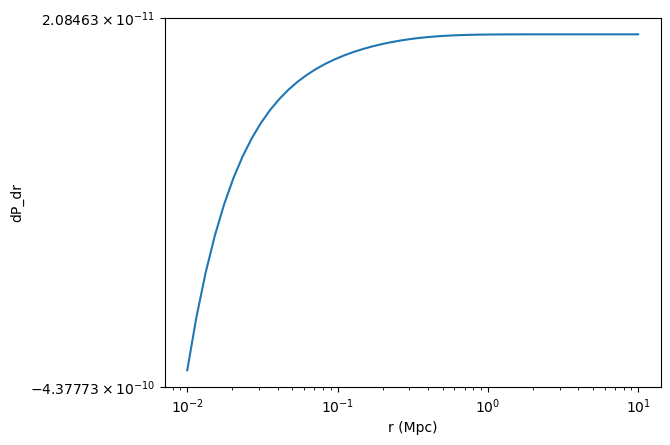

In [275]:
plt.plot(rs, [dP_dr(r, R500, M500, z) for r in rs])
#plt.plot(rs, dP_dr(rs, R500, M500, z))
plt.xlabel('r (Mpc)')
plt.ylabel('dP_dr')
plt.yscale('symlog')
plt.xscale('log')

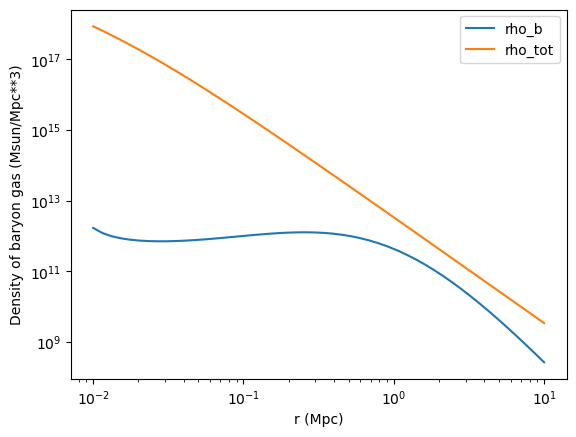

In [288]:

plt.loglog(rs, rho_g(rs, R500, M500, z), label='rho_b')
plt.loglog(rs, rho_nfw(rs.value, M500, R500), label='rho_tot')
plt.xlabel('r (Mpc)')
plt.ylabel('Density of baryon gas (Msun/Mpc**3)')
plt.legend()

Text(0, 0.5, 'Temperature of baryon gas (GeV)')

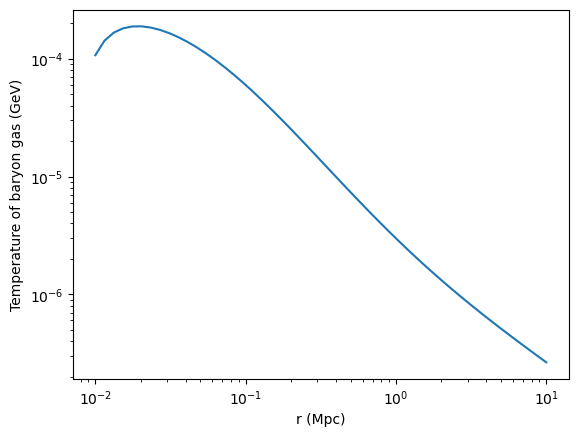

In [291]:
plt.loglog(rs, T_g(rs.value, R500, M500, z))
plt.xlabel('r (Mpc)')
plt.ylabel('Temperature of baryon gas (GeV)')

In [187]:
#plt.loglog(rs, dT_dr(rs, R500, M500, z))
#plt.xlabel('r (Mpc)')
#plt.ylabel('dT/dr (GeV/Mpc)')

Text(0, 0.5, 'dP/dT (erg/(cm^3*GeV))')

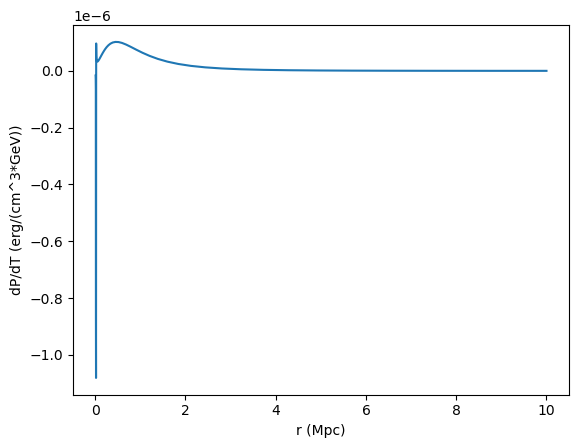

In [293]:
# TODO: think about if the way i made this makes sense
plt.plot(rs, np.gradient(Pg(rs/R500, z, M500).to(u.erg*u.cm**-3), T_g(rs.value, R500, M500, z)))
#plt.xscale('log')
#plt.yscale('symlog')
plt.xlabel('r (Mpc)')
plt.ylabel('dP/dT (erg/(cm^3*GeV))')